In [0]:
#@title Imports and Global Variables (run this cell first)  { display-mode: "form" }
"""
The book uses a custom matplotlibrc file, which provides the unique styles for
matplotlib plots. If executing this book, and you wish to use the book's
styling, provided are two options:
    1. Overwrite your own matplotlibrc file with the rc-file provided in the
       book's styles/ dir. See http://matplotlib.org/users/customizing.html
    2. Also in the styles is  bmh_matplotlibrc.json file. This can be used to
       update the styles in only this notebook. Try running the following code:

        import json
        s = json.load(open("../styles/bmh_matplotlibrc.json"))
        matplotlib.rcParams.update(s)
"""
!pip3 install -q wget
from __future__ import absolute_import, division, print_function
#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
        `namedtuple` or combinations thereof.

    Returns:
        ndarrays: Object with same structure as `tensors` except with `Tensor` or
          `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

In [0]:
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import dump 
from sklearn.compose import TransformedTargetRegressor

from pandas import read_csv 
from pandas import set_option

from google.colab import files

import wget

print(tf.version.VERSION)
print(tf.keras.__version__)


density_param = {'normed': True}

if not os.path.exists('./csv'):
  os.mkdir('./csv')
  
if not os.path.exists('./figures'):
  os.mkdir('./figures')  

1.14.0
2.2.4-tf


In [0]:
# Convert an array of values into a dataset matrix 
def create_dataset(dataset, profile_points, inputs=3, outputs=1, look_back=1): 
  
  dataX, dataY = [], [] 
  for i in range(0,len(dataset)-look_back*profile_points): 
    dataX.append(dataset[i, 0:inputs])
    dataY.append(dataset[i + look_back*profile_points, inputs-outputs:inputs]) 
  
  return np.array(dataX), np.array(dataY)


In [0]:
if not os.path.exists('boundary.csv'):
  url = 'https://raw.githubusercontent.com/vitorvilela/general-database/master/boundary.csv'
  dataset_path = wget.download(url)
  print(dataset_path)
else:
  dataset_path = 'boundary.csv'


boundary.csv


In [0]:
# User input

download_files = False

print_former = False
print_intermediate = False
print_data_info = False
print_prediction = False

# Number of points in profile. See the first row of the boundary.csv
profile_points = 127 

# Number of samples. In the first column of the boundary.csv: (last_i - first_i + 1)
first_i = 90
last_i = 543
number_of_samples = last_i-first_i+1
print('#samples: ', number_of_samples)

# Train proportion
train_proportion = 0.7

# Temporal stencil
look_back = 1 

# Number of inputs and outputs
inputs = 3
outputs = 1

# Constant random seed for reproducibility 
np.random.seed(7) 

#samples:  454


In [0]:
targets = ['ux', 'uy', 'f']
i = 2

target = targets[i] 
  
indices = ['dt', 'y', target]

# Load the dataset
dataframe = read_csv(dataset_path, names=indices, usecols=[2,4,5+i], engine='python', skiprows=2)

if target == 'f':
  dataframe[target].mask(dataframe[target] < 1e-3, 1e-3, inplace=True)

print(dataframe.keys(), '\n')
print(dataframe.loc[:5, target], '\n')  

print('dataframe describe\n', dataframe.describe(), '\n')
set_option('precision', 2)

dataset = dataframe.values 
dataset = dataset.astype('float32')

if print_former:
  filename = './csv/dataset_{}.csv'.format(target)
  np.savetxt(filename, dataset, delimiter=',')
  print('dataset.shape: ', dataset.shape)

Index(['dt', 'y', 'f'], dtype='object') 

0    1.00e-03
1    1.00e-03
2    1.00e-03
3    1.00e-03
4    1.00e-03
5    1.00e-03
Name: f, dtype: float64 

dataframe describe
              dt         y         f
count  5.77e+04  57658.00  5.77e+04
mean   3.91e-02      0.00  9.65e-02
std    7.35e-07      1.79  2.53e-01
min    3.91e-02     -3.08  1.00e-03
25%    3.91e-02     -1.56  1.00e-03
50%    3.91e-02      0.00  1.00e-03
75%    3.91e-02      1.56  1.00e-03
max    3.91e-02      3.08  1.00e+00 



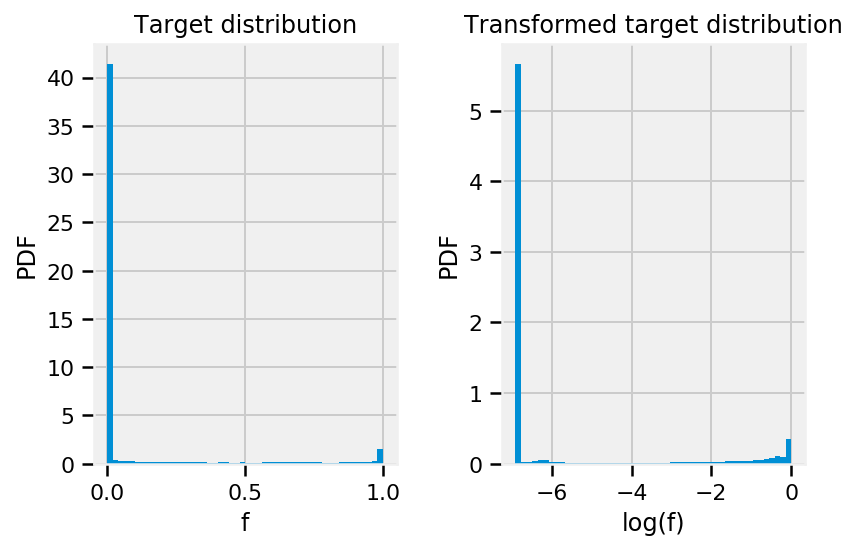

<Figure size 432x288 with 0 Axes>

In [0]:
  figure, (ax0, ax1) = plt.subplots(1, 2)
 
  ax0.hist(dataframe.loc[:,target], bins=50, **density_param)
  ax0.set_ylabel('PDF')
  ax0.set_xlabel(target)
  ax0.set_title('Target distribution')
    
  ax1.hist(dataframe.loc[:,target].apply(np.log), bins=50, **density_param)
  ax1.set_ylabel('PDF')
  ax1.set_xlabel('log({})'.format(target))
  ax1.set_title('Transformed target distribution')
 
  figure.tight_layout() # rect=[0.05, 0.05, 0.95, 0.95]

  figname = './figures/pdf_{}.png'.format(target)
  plt.show()
  plt.savefig(figname)
  figure.clear()
  plt.close(figure)  
  

In [0]:
#dataframe[target] = dataframe[target].apply(np.log)

In [0]:
 # Split into train and test datasets. Order matters!
  train_samples = int(train_proportion*number_of_samples)  
  train_size = int(train_samples*(len(dataset)/number_of_samples)) 
  test_size = len(dataset) - train_size + look_back*profile_points
  train, test = dataset[0:train_size,:], dataset[train_size-look_back*profile_points:len(dataset),:]
   
  if print_intermediate:
    print('train_samples: ', train_samples)
    print('profile points: ', int(len(dataset)/number_of_samples), ' of theoretical ', profile_points)
    print('train_size: ', train_size)
    print('test_size: ', test_size)    
    filename = './csv/intermediate_train_{}.csv'.format(target)
    np.savetxt(filename, train, delimiter=',')
    filename = './csv/intermediate_test_{}.csv'.format(target)
    np.savetxt(filename, test, delimiter=',')
    print(filename)


  # Reshape into X=t and Y=t+1 
  trainX, trainY = create_dataset(train, profile_points, inputs, outputs, look_back) 
  testX, testY = create_dataset(test, profile_points, inputs, outputs, look_back)
  
  
  if print_data_info: 
    filename = './csv/trainX_{}.csv'.format(target)
    np.savetxt(filename, trainX, delimiter=',')
    filename = './csv/trainY_{}.csv'.format(target)
    np.savetxt(filename, trainY, delimiter=',')
    filename = './csv/testX_{}.csv'.format(target)
    np.savetxt(filename, testX, delimiter=',')
    filename = './csv/trainY_{}.csv'.format(target)
    np.savetxt(filename, testY, delimiter=',')
    trainX_size = len(trainX)
    testX_size = len(testX)
    trainY_size = len(trainY)
    testY_size = len(testY)
    print('\n')
    print('type(trainX): ', type(trainX)) 
    print('trainX.shape: ', trainX.shape) 
    print('trainX_size: ', trainX_size)
    print('testX_size: ', testX_size)
    print('type(trainY): ', type(trainY)) 
    print('trainY.shape: ', trainY.shape) 
    print('trainY_size: ', trainY_size)
    print('testY_size: ', testY_size)

In [0]:
# Scaler
scaler = StandardScaler().fit(trainX)
trainX = scaler.transform(trainX)
scalername = 'scaler-{}.sav'.format(target) 
dump(scaler, scalername) 

['scaler-f.sav']

In [0]:
if download_files:
  files.download(scalername) 

In [0]:
# Best config for...
# ux --> activation: selu, lr: 0.0001, optimizer: adam, loss: mae
# uy --> activation: selu, lr: 0.0001, optimizer: adam, loss: mae
# f --> activation: selu, lr: 0.0001, optimizer: adam, loss: mae

# Activation
activation = 'selu'

# Batch normalization
batchnorm = False

# Dropout
dropout = 0.1

# Initializer
kernel_initializer = 'glorot_uniform' # 'normal'

# Learning rate and decay
lr = 1.e-4
lr_decay = 1.e-5

# Optimizer
#sgd = tf.train.GradientDescentOptimizer(learning_rate=lr, decay=lrdecay, momentum=0.9, nesterov=True)
#rmsprop = tf.train.RMSPropOptimizer(learning_rate=lr, rho=0.9, epsilon=None, decay=lrdecay)
adam = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.9, beta2=0.999)
optimizer = adam
optimizer_name = 'adam'

# Loss 
# ('mse' 'mape' 'mae' 'msle' 'logcosh')
loss = 'mae' 

# Metrics 
# ('mse' 'mae', 'mape', 'cosine') - regression  
# ('acc') - classification
metrics = ['mse', 'mae', 'mape']

In [0]:
# Best config for...
# ux --> hidden_layers: 2, neurons: profile_points
# uy --> hidden_layers: 2, neurons: profile_points
# f --> hidden_layers: 2, neurons: profile_points

hidden_layers = 2
neurons = profile_points

model = tf.keras.Sequential([                             
layers.Dense(profile_points, input_shape=(inputs,), kernel_initializer=kernel_initializer),
#layers.BatchNormalization(),
layers.Activation(activation=activation),
layers.Dropout(rate=dropout),
layers.Dense(profile_points, kernel_initializer=kernel_initializer),
#layers.BatchNormalization(),
layers.Activation(activation=activation),
layers.Dropout(rate=dropout),
layers.Dense(outputs, kernel_initializer=kernel_initializer)])

model.summary()

init = tf.global_variables_initializer()
saver_def = tf.train.Saver().as_saver_def()
with open('graph.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())   

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 127)               508       
_________________________________________________________________
activation_4 (Activation)    (None, 127)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 127)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 127)               16256     
_________________________________________________________________
activation_5 (Activation)    (None, 127)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 127)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [0]:
if download_files:
  files.download('graph.pb') 

In [0]:
model.compile(optimizer=adam,
              loss=loss,
              metrics=metrics)

In [0]:
# Best config for...
# ux --> epochs: 500, batch_size: 10*profile_points
# uy --> epochs: 500, batch_size: 10*profile_points
# f --> epochs: 500, batch_size: 10*profile_points

# Epochs
epochs = 500

# Batch
batch_size = 10*profile_points # 40132 

In [0]:
print('\nTrain stage for ', target)  
  
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)


Train stage for  f
Epoch 1/500
40132/40132 [==============================] - 1s 29us/sample - loss: 0.1660 - mean_squared_error: 0.0653 - mean_absolute_error: 0.1660 - mean_absolute_percentage_error: 11804.9990
Epoch 2/500
40132/40132 [==============================] - 1s 21us/sample - loss: 0.1376 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1376 - mean_absolute_percentage_error: 10741.7822
Epoch 3/500
40132/40132 [==============================] - 0s 6us/sample - loss: 0.1269 - mean_squared_error: 0.0328 - mean_absolute_error: 0.1269 - mean_absolute_percentage_error: 9891.3262
Epoch 4/500
40132/40132 [==============================] - 0s 6us/sample - loss: 0.1177 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1177 - mean_absolute_percentage_error: 9122.1445
Epoch 5/500
40132/40132 [==============================] - 0s 5us/sample - loss: 0.1070 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1070 - mean_absolute_percentage_error: 8287.0156
Epoch 6/500
40132/401

In [0]:
casename = 'lr_{}_activation_{}_optimizer_{}_hiddenlayers_{}_\
neurons_{}_batchnorm_{}_dropout_{}_batchsize_{}_loss_{}_\
epochs_{}'.format(lr, activation, optimizer_name, hidden_layers, neurons, batchnorm, dropout, batch_size, loss, epochs)

print(casename)

lr_0.0001_activation_selu_optimizer_adam_hiddenlayers_2_neurons_127_batchnorm_False_dropout_0.1_batchsize_1270_loss_mae_epochs_500


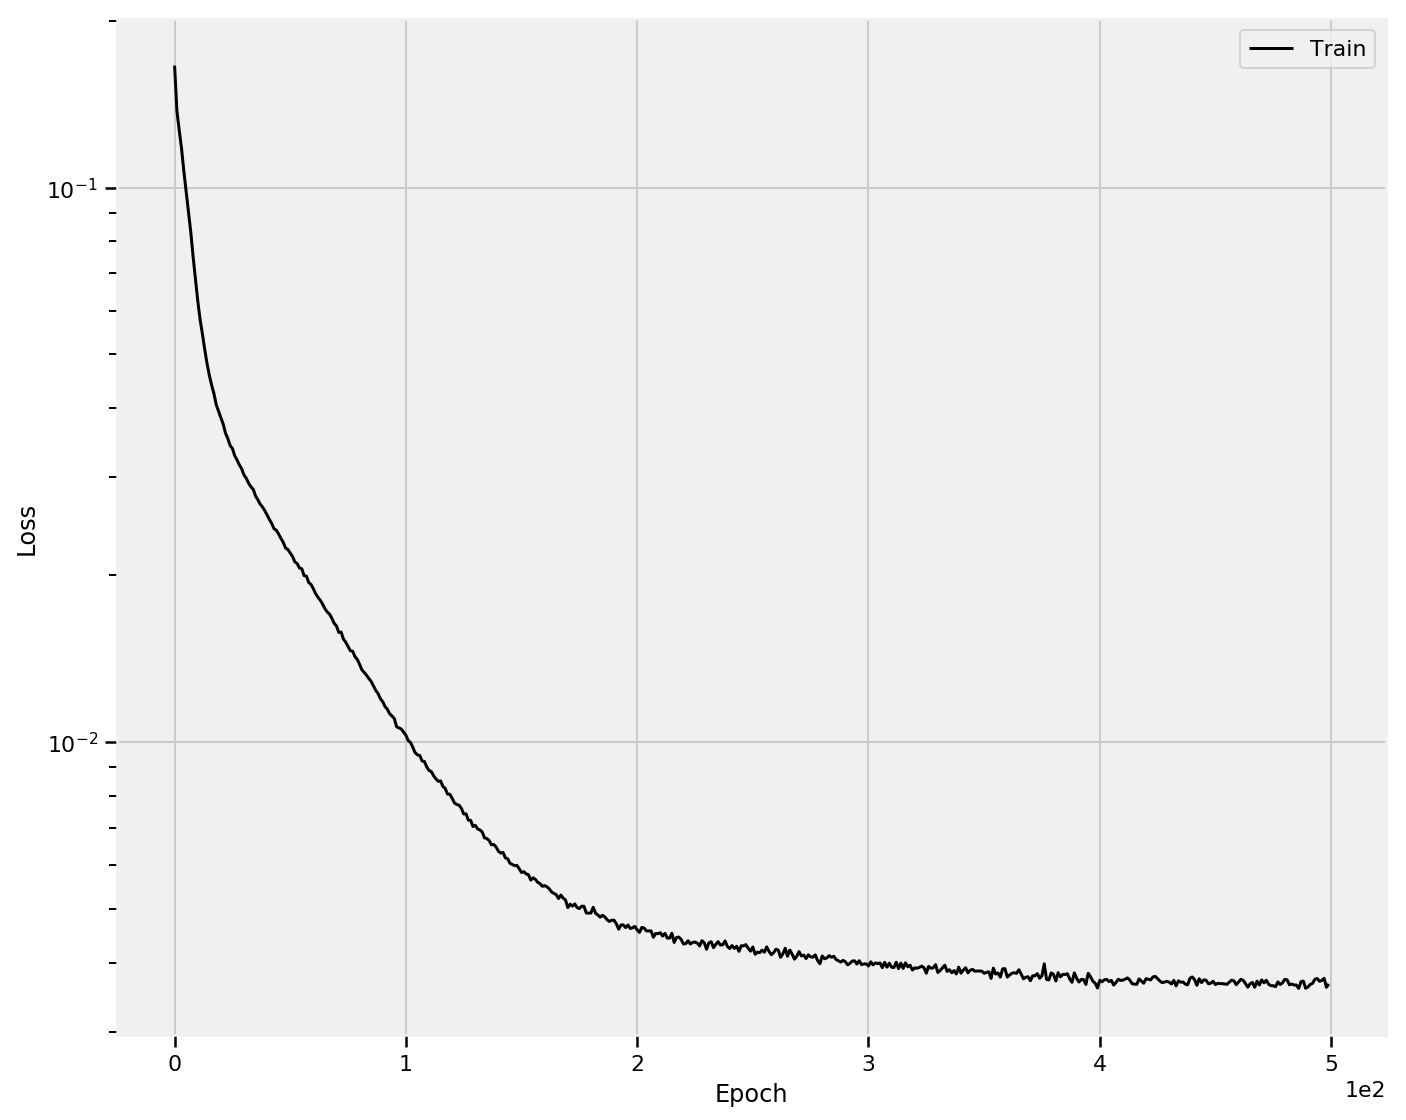

<Figure size 432x288 with 0 Axes>

In [0]:
# print(history.history.keys())
  
# Summarize history for loss
figure = plt.figure(figsize=(10., 8.))
plt.semilogy(history.history['loss'], 'k-')
plt.ylabel('Loss', rotation='vertical')
plt.xlabel('Epoch')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
figname = './figures/Loss_{}_casename_{}.png'.format(loss, casename)
plt.show()
plt.savefig(figname)
figure.clear()
plt.close(figure)

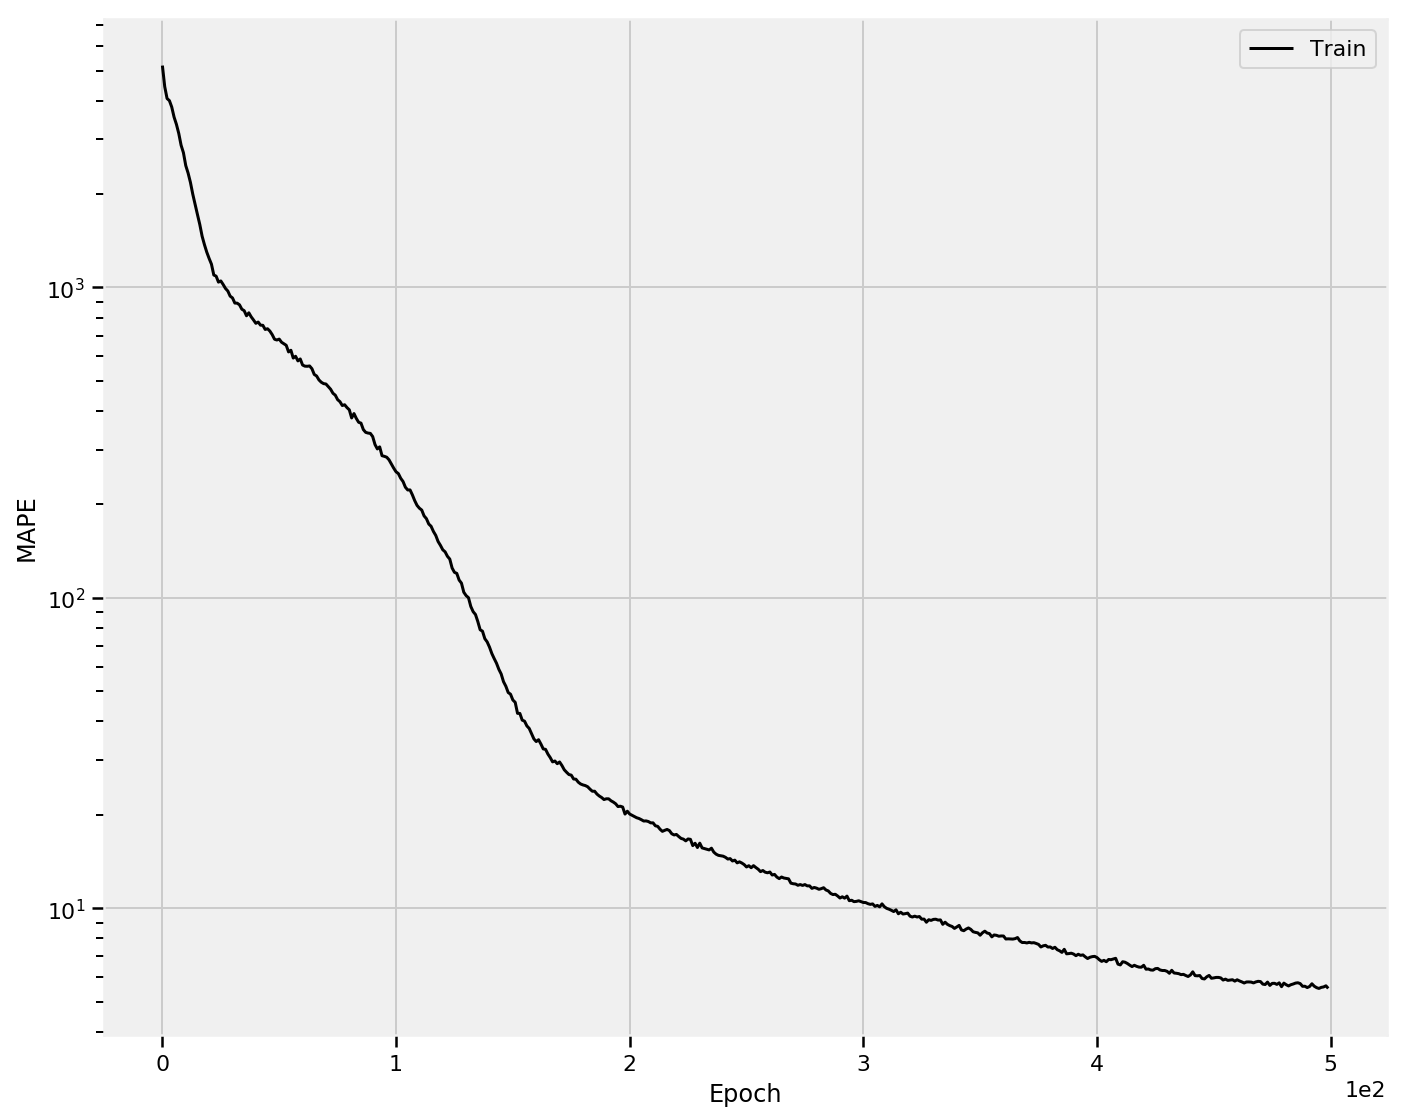

<Figure size 432x288 with 0 Axes>

In [0]:
# Summarize history for mape
figure = plt.figure(figsize=(10., 8.))
plt.semilogy(history.history['mean_absolute_percentage_error'], 'k-')
plt.ylabel('MAPE', rotation='vertical')
plt.xlabel('Epoch')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
plt.legend(['Train'], loc='upper right')
plt.tight_layout()
figname = './figures/MAPE_{}.png'.format(casename)
plt.show()
plt.savefig(figname)
figure.clear()
plt.close(figure)

In [0]:
  # Estimate model performance 
  trainScore = model.evaluate(trainX, trainY, verbose=0) 
  print('Train Score: %.2e Loss (%.2e RMSE) | %.2f%% MAPE' % (trainScore[0], np.sqrt(trainScore[1]), trainScore[-1]))   

Train Score: 1.89e-03 Loss (5.49e-03 RMSE) | 10.06% MAPE


In [0]:
# Scale test data
testX = scaler.transform(testX)
  
testScore = model.evaluate(testX, testY, verbose=0) 
print('Test Score: %.2e Loss (%.2e RMSE) | %.2f%% MAPE' % (testScore[0], np.sqrt(testScore[1]), testScore[-1]))


Test Score: 2.53e-03 Loss (5.67e-03 RMSE) | 9.60% MAPE


In [0]:
# Save weights to a tensorflow checkpoint file
model.save_weights('./checkpoints/{}/checkpoint'.format(target))

In [0]:
if download_files:
  !zip -r /content/checkpoints.zip /content/checkpoints
  files.download('checkpoints.zip') 

updating: content/checkpoints/ (stored 0%)
updating: content/checkpoints/uy/ (stored 0%)
updating: content/checkpoints/uy/checkpoint (deflated 48%)
updating: content/checkpoints/uy/checkpoint.index (deflated 65%)
updating: content/checkpoints/uy/checkpoint.data-00001-of-00002 (deflated 80%)
updating: content/checkpoints/uy/checkpoint.data-00000-of-00002 (deflated 8%)
  adding: content/checkpoints/f/ (stored 0%)
  adding: content/checkpoints/f/checkpoint (deflated 48%)
  adding: content/checkpoints/f/checkpoint.index (deflated 65%)
  adding: content/checkpoints/f/checkpoint.data-00001-of-00002 (deflated 80%)
  adding: content/checkpoints/f/checkpoint.data-00000-of-00002 (deflated 8%)



Print stage for  f


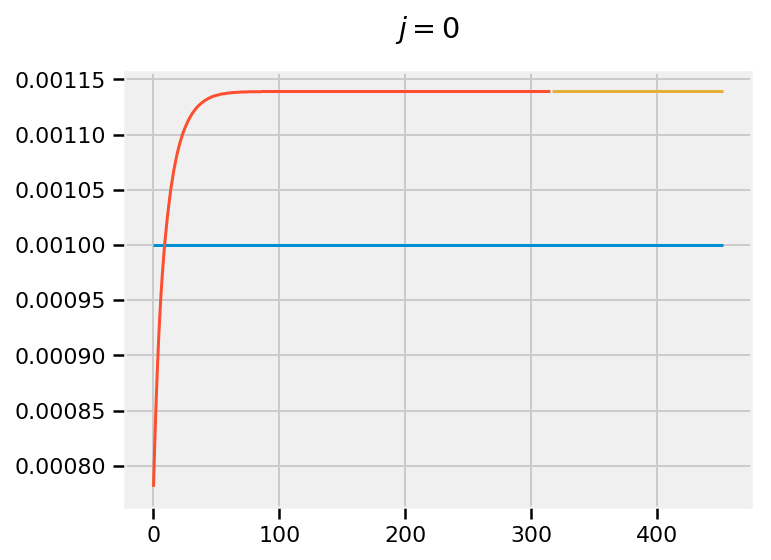

<Figure size 432x288 with 0 Axes>

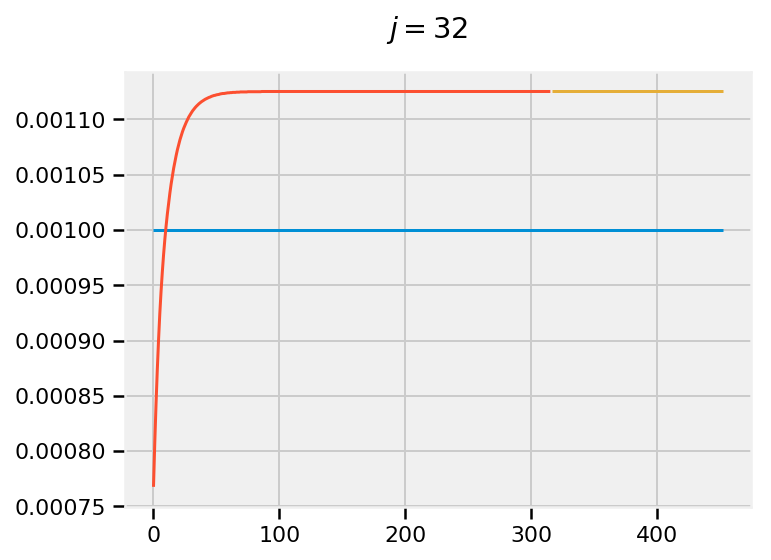

<Figure size 432x288 with 0 Axes>

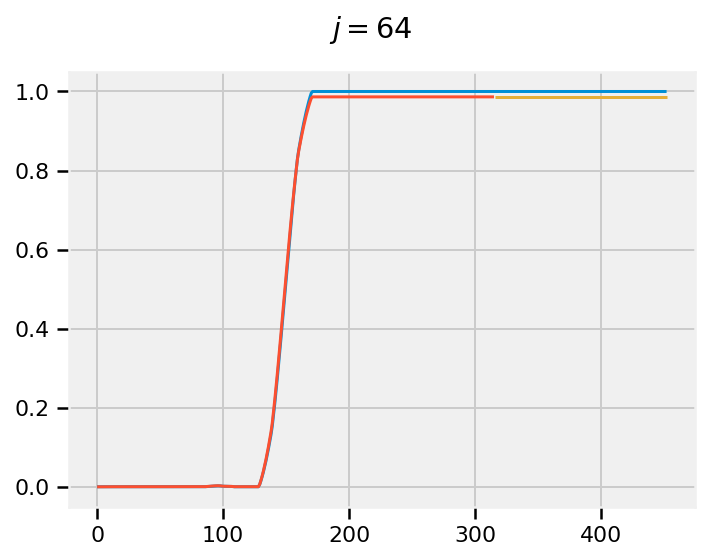

<Figure size 432x288 with 0 Axes>

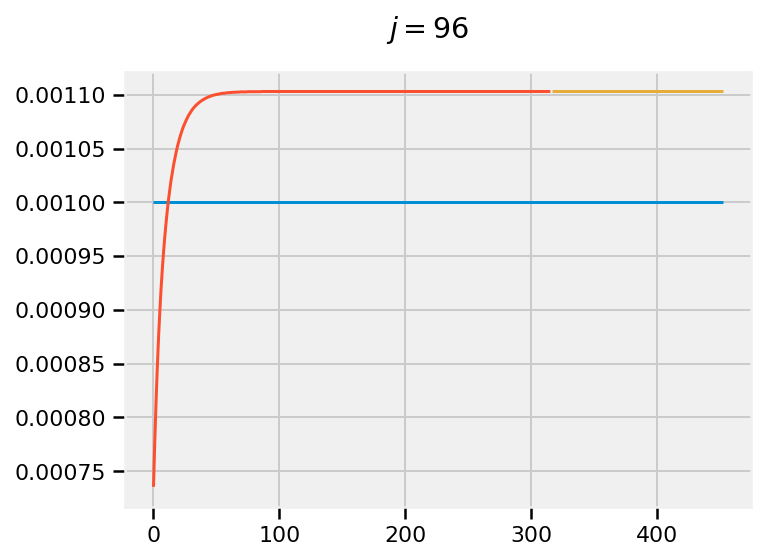

<Figure size 432x288 with 0 Axes>

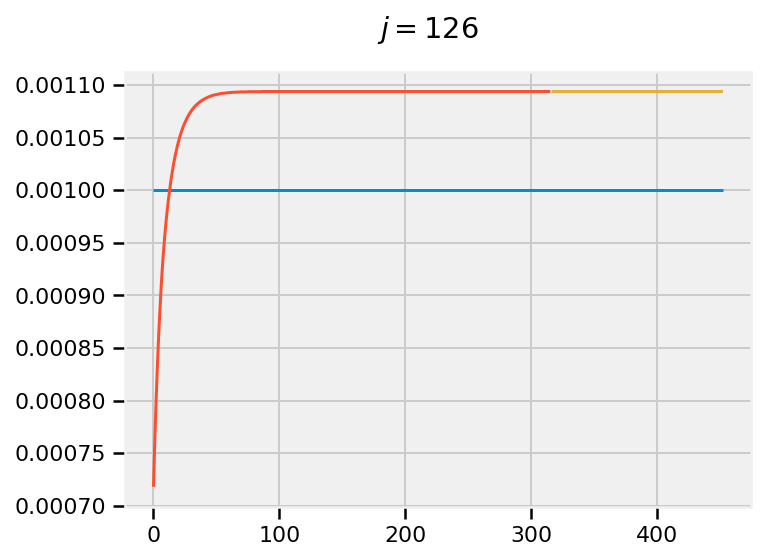

<Figure size 432x288 with 0 Axes>

In [0]:
trainPredict = model.predict(trainX)   
testPredict = model.predict(testX) 
  
print('\nPrint stage for ', target)
  
# From 0 to 126
# Test with 0, 64 and 126
#point_y = 64
for point_y in (0, 32, 64, 96, 126):

  figure = plt.figure(figsize=(5., 4.))
  
  figname = './figures/prediction_{}_y_{}.png'.format(target, point_y)

  target_predict_plot = 0
  target_dataset_plot = 2
    
  datasetplot = dataset[point_y:len(dataset)-look_back*profile_points:profile_points,target_dataset_plot]

  trainPredictPlot = np.empty_like(datasetplot) 
  trainPredictPlot[:] = np.nan 
    
  trainPredictPlot = trainPredict[point_y:len(trainPredict):profile_points,target_predict_plot]

  testPredictPlot = np.empty_like(datasetplot) 
  testPredictPlot[:] = np.nan 
    
  testPredictPlot[len(trainPredictPlot):] = testPredict[point_y:len(testPredict):profile_points,target_predict_plot]
    
  if print_prediction:
    filename = 'datasetplot_'+target+'.csv'
    np.savetxt(filename, datasetplot, delimiter=',')
    print('datasetplot: ', datasetplot.shape)

    print('trainPredict: ', trainPredict.shape)
    print('trainPredictPlot before: ', trainPredictPlot.shape)
    print('trainPredictPlot after: ', trainPredictPlot.shape)
    filename = './csv/trainPredictPlot_{}.csv'.format(target)
    np.savetxt(filename, trainPredictPlot, delimiter=',')

    print('testPredict: ', testPredict.shape)
    print('testPredictPlot before: ', testPredictPlot.shape)
    print('testPredictPlot after: ', testPredictPlot.shape)
    filename = './csv/testPredictPlot_{}.csv'.format(target)
    np.savetxt(filename, testPredictPlot, delimiter=',')

  # Plot baseline and predictions 
  figure.suptitle('$j={}$'.format(point_y))
  
  plt.plot(datasetplot)
  plt.plot(trainPredictPlot) 
  plt.plot(testPredictPlot) 
    
  plt.show()
  plt.savefig(figname)
  figure.clear()
  plt.close(figure)

In [0]:
# Downloads

#!zip -r /content/figures.zip /content/figures
#files.download('figures.zip') 

#!zip -r /content/csv.zip /content/csv
#files.download('csv.zip') 



  adding: content/scalers/ (stored 0%)
  adding: content/scalers/scaler-ux.sav (deflated 23%)
